In [1]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using FluxExtensions
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate

push!(LOAD_PATH, "../", "/home/jan/dev/anomaly detection/anomaly_detection/src")
using KNNmem
using AnomalyDetection

include("../train_and_track.jl");

In [2]:
# Prepare data

dataPath = "/home/jan/dev/data/loda/public/datasets/numerical"
allData = AnomalyDetection.loaddata(dataPath)

dataset = allData["abalone"]
train, test, clusterdness = AnomalyDetection.makeset(dataset, 0.9, "normal", 0.05, "high")
inputSize = size(train.data, 1)

10

In [3]:
# Model with memory

memoryModel = Chain(
  FluxExtensions.ResDense(inputSize, 32, relu),
  FluxExtensions.ResDense(32, 32, relu),
  FluxExtensions.ResDense(32, 2, relu))

memory = KNNmemory(200, 2, 32, 10)

# Model without memory

classicModel = Chain(
  FluxExtensions.ResDense(inputSize, 32, relu),
  FluxExtensions.ResDense(32, 32, relu),
  FluxExtensions.ResDense(32, 2, relu),
  softmax)

Chain(ResDense(Dense(32, 32, NNlib.relu)), ResDense(Dense(32, 32, NNlib.relu)), ResDense(Dense(2, 2, NNlib.relu)), NNlib.softmax)

In [4]:
# Training setup

memLoss(x, y) = trainQuery!(memory, memoryModel(x), y)
memOpt = ADAM(params(memoryModel))

classicLoss(x, y) = crossentropy(classicModel(x), y)
classicOpt = ADAM(params(classicModel))

iterations = 1000
batchSize = 1000
printInterationCount = 100

100

In [5]:
memHistory = trainAndTrack!(memLoss, memOpt, iterations, batchSize, train.data, train.labels, test.data, test.labels, printInterationCount)
classicHistory = trainAndTrack!(classicLoss, classicOpt, iterations, batchSize, train.data, Flux.onehotbatch(train.labels, 0:1), test.data, Flux.onehotbatch(test.labels, 0:1), printInterationCount)

0.03005183380503671
0.08933897549956367
0.09731652313332667
0.05084477508603673
0.09187447992022961
0.07424186084413492
0.09914453251611667
0.03465907281064253
0.06594088647997423
0.09344308826934075
0.0928288196692579
0.07439527341211505
0.07218573128510426
0.07717806202678987
0.07984188093096738
0.05995208422273501
0.06963753391915242
0.08438075781122967
0.06981040091065567
0.06837140469397258


MVHistory{ValueHistories.History}
  :test => 10 elements {Int64,Float64}
  :train => 10 elements {Int64,Float64}

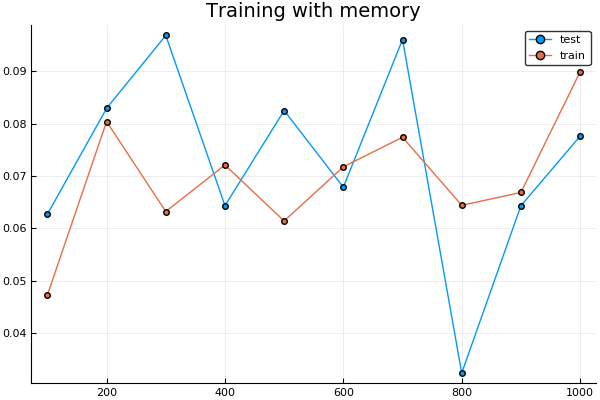

In [6]:
# Plot training

using Plots
pyplot()

plot(memHistory)
plot!(title = "Training with memory")

In [7]:
plot(classicHistory)
plot!(title = "Training without memory")abalone

LoadError: [91mUndefVarError: abalone not defined[39m

In [8]:
# ROC with memory

rocData = roc(test.labels, query(memory, memoryModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 11
  n = 216
  tp = 2
  tn = 201
  fp = 15
  fn = 9
precision: 0.11764705882352941
f1score: 0.14285714285714285
recall: 0.18181818181818182
false positive rate: 0.06944444444444445
equal error rate: 0.4438131313131313


In [9]:
# ROC without memory

rocData = roc(test.labels, argmax(classicModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 11
  n = 216
  tp = 5
  tn = 0
  fp = 216
  fn = 0
precision: 0.02262443438914027
f1score: 0.04424778761061947
recall: 0.45454545454545453
false positive rate: 1.0
equal error rate: 0.5
